Number of hours with visits > 20 for each station:
                                   level_0  hours_above_20
10               Larrabee St & Webster Ave               4
5                Desplaines St & Kinzie St               3
2                        Clark St & Elm St               2
4                    Dearborn St & Erie St               2
9               Lake Shore Dr & North Blvd               2
11            Sheffield Ave & Waveland Ave               2
0                  Broadway & Cornelia Ave               1
1                  Clark St & Armitage Ave               1
3                   Clark St & Lincoln Ave               1
6   HUBBARD ST BIKE CHECKING (LBS-WH-TEST)               1
7                   Halsted St & Roscoe St               1
8               Indiana Ave & Roosevelt Rd               1
12                   Wells St & Concord Ln               1


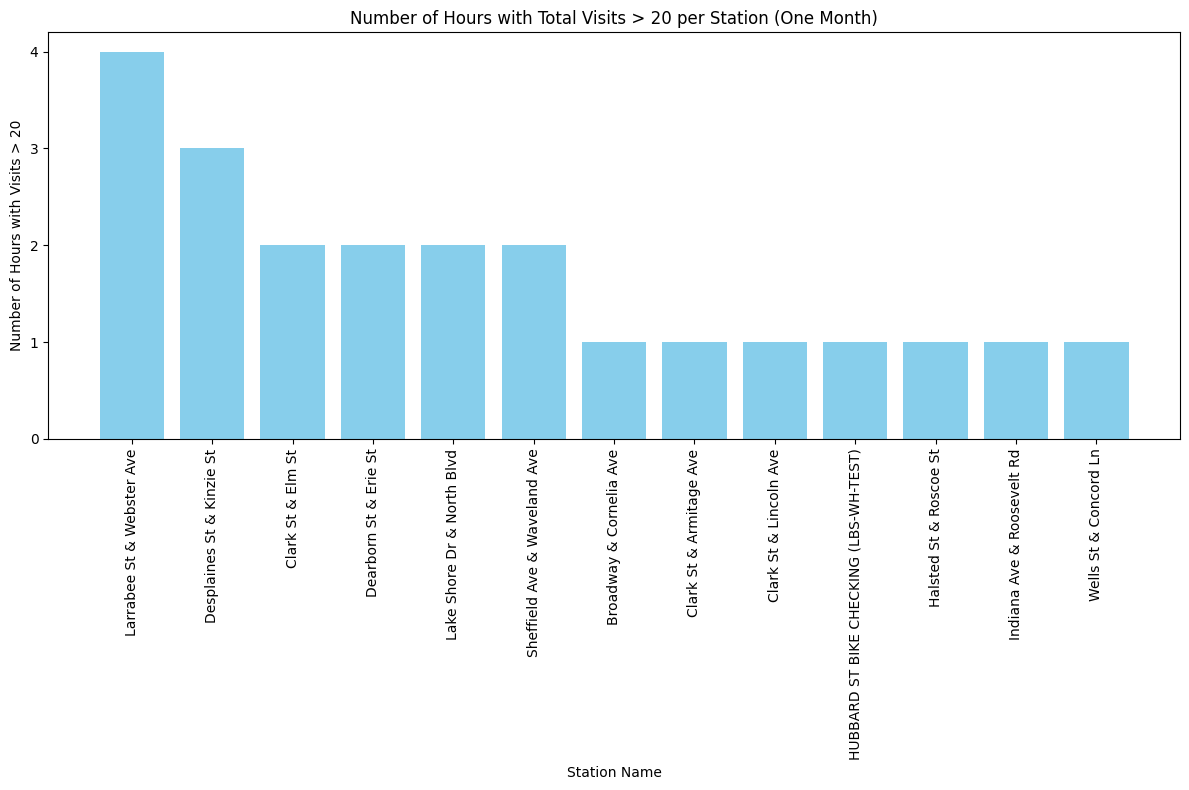

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic

# Load bike trip data
data = pd.read_csv('zhong.csv')

# ----------------------------
# Step 1: Count visits by hour
# ----------------------------
# Convert time columns to datetime format and extract hourly intervals
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['hour'] = data['start_time'].dt.floor('H')  # Round to the nearest hour

# Count hourly outflows (departures)
hourly_outflow = data.groupby(['start_station_name', 'hour']).size().rename('outflow')

# Count hourly inflows (arrivals)
hourly_inflow = data.groupby(['end_station_name', 'hour']).size().rename('inflow')

# Combine inflow and outflow statistics
hourly_stats = pd.concat([hourly_outflow, hourly_inflow], axis=1).fillna(0)

# Calculate total visits (sum of inflow and outflow)
hourly_stats['total_visits'] = hourly_stats['inflow'] + hourly_stats['outflow']
# ----------------------------
# Step 2: Filter records with total_visits > 20
# ----------------------------
# Reset index to convert multi-level index into columns
hourly_stats_reset = hourly_stats.reset_index()

# Filter records where total visits exceed 20
top_visits = hourly_stats_reset[hourly_stats_reset['total_visits'] > 20]

# Count the number of hours with visits > 20 for each station
top_visits_count = top_visits.groupby('level_0').size().reset_index(name='hours_above_20')

# Sort the results by the number of hours in descending order
top_visits_count = top_visits_count.sort_values(by='hours_above_20', ascending=False)

# Print the data
print("Number of hours with visits > 20 for each station:")
print(top_visits_count)

# ----------------------------
# Plot bar chart
# ----------------------------
y_ticks = np.arange(0, top_visits_count['hours_above_20'].max() + 1, 1)

plt.figure(figsize=(12, 8))
plt.bar(top_visits_count['level_0'], top_visits_count['hours_above_20'], color='skyblue')
plt.xticks(rotation=90)
plt.yticks(y_ticks)  # Set y-axis ticks to integers
plt.xlabel('Station Name')
plt.ylabel('Number of Hours with Visits > 20')
plt.title('Number of Hours with Total Visits > 20 per Station (One Month)')
plt.tight_layout()
plt.show()



In [4]:
# ----------------------------
# Step 3: Count stations with more than 25 days without visits
# ----------------------------
# Extract the date from the start_time column
data['date'] = data['start_time'].dt.date

# Count daily visits for each station
station_daily_visits = data.groupby(['start_station_name', 'date']).size().unstack(fill_value=0)

# Count the number of days each station had no visits
days_not_visited = (station_daily_visits == 0).sum(axis=1)

# Filter stations with more than 25 days without visits
stations_over_25_days_no_visits = days_not_visited[days_not_visited > 25]

# Sort the results by the number of days in descending order
stations_over_25_days_no_visits = stations_over_25_days_no_visits.sort_values(ascending=False)

# Print the results
print("Stations with more than 25 days without visits:")
print(stations_over_25_days_no_visits)

Stations with more than 25 days without visits:
start_station_name
HUBBARD ST BIKE CHECKING (LBS-WH-TEST)    29
Stewart Ave & 63rd St (*)                 29
Vernon Ave & 79th St                      29
Throop St & 52nd St                       29
Damen Ave & 59th St                       29
Lakefront Trail & Wilson Ave              29
Laramie Ave & Gladys Ave                  29
Michigan Ave & 71st St                    29
Marshfield Ave & 44th St                  29
Racine Ave & 61st St                      29
Burnham Harbor                            29
Rainbow Beach                             29
Ashland Ave & 63rd St                     29
Ashland Ave & 50th St                     29
Halsted St & 69th St                      29
Halsted St & 56th St                      28
Stony Island Ave & 82nd St                28
Racine Ave & 65th St                      28
Kostner Ave & Lake St                     28
Kostner Ave & Adams St                    28
Shields Ave & 43rd St            

Details of stations with more than 25 days without visits and their nearby alternatives:
Station: HUBBARD ST BIKE CHECKING (LBS-WH-TEST), No-Visit Days: 29, Nearby Stations: [('Damen Ave & Grand Ave', 0.34238023817785534)]
Station: Stewart Ave & 63rd St (*), No-Visit Days: 29, Nearby Stations: [('Wentworth Ave & 63rd St', 0.42529879730129466)]
Station: Vernon Ave & 79th St, No-Visit Days: 29, Nearby Stations: []
Station: Throop St & 52nd St, No-Visit Days: 29, Nearby Stations: []
Station: Damen Ave & 59th St, No-Visit Days: 29, Nearby Stations: []
Station: Lakefront Trail & Wilson Ave, No-Visit Days: 29, Nearby Stations: [('Clarendon Ave & Leland Ave', 0.4528904446497606)]
Station: Laramie Ave & Gladys Ave, No-Visit Days: 29, Nearby Stations: [('Laramie Ave & Madison St', 0.488712026714292)]
Station: Michigan Ave & 71st St, No-Visit Days: 29, Nearby Stations: [('Calumet Ave & 71st St', 0.3997586834880011)]
Station: Marshfield Ave & 44th St, No-Visit Days: 29, Nearby Stations: []
Statio

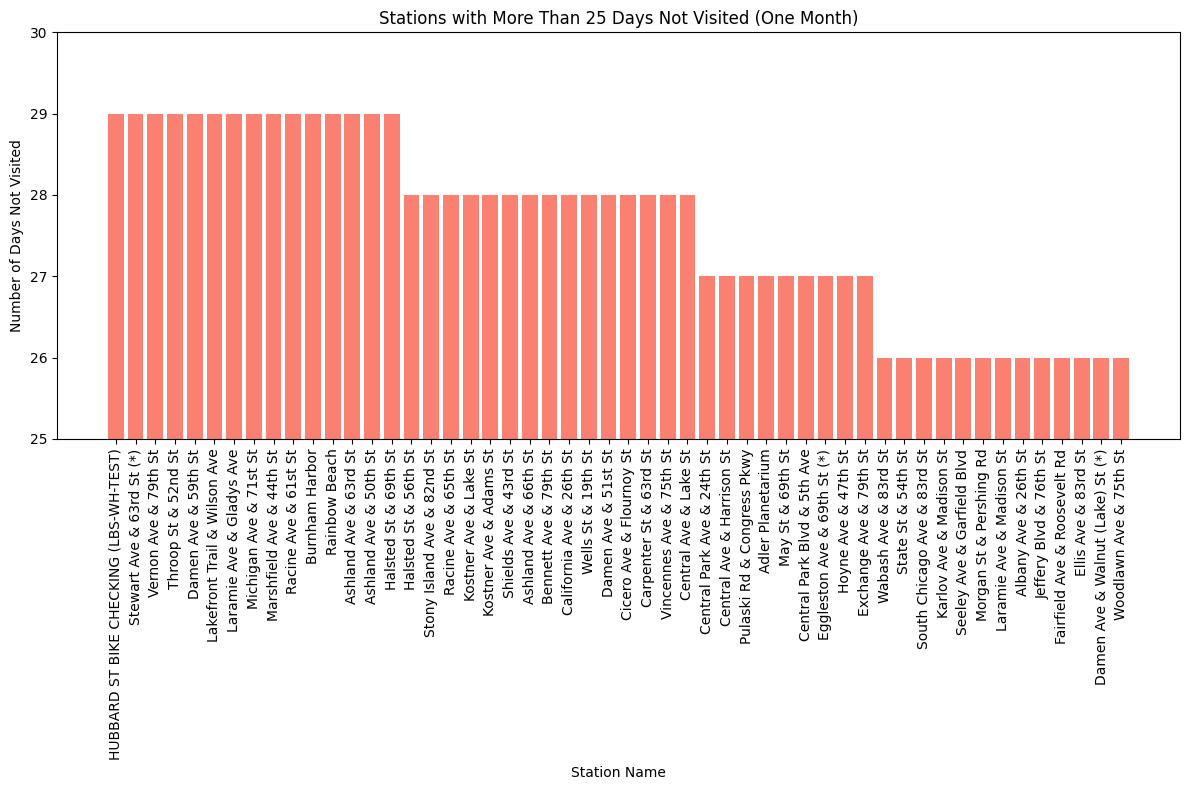

In [6]:
# ----------------------------
# Step 4: Check proximity of alternative stations
# ----------------------------
# Extract station coordinates
station_coords = data[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates()
station_coords.columns = ['station_name', 'lat', 'lng']

# Define a function to find nearby stations
def find_nearby_stations(station_name, lat, lng, radius=0.5):
    nearby_stations = []
    for _, row in station_coords.iterrows():
        distance = geodesic((lat, lng), (row['lat'], row['lng'])).kilometers
        if distance <= radius and row['station_name'] != station_name:
            nearby_stations.append((row['station_name'], distance))
    return nearby_stations

# Check each station with more than 25 days without visits
no_visit_station_details = []
stations_with_alternatives = []  # Track stations with nearby alternatives
for station in stations_over_25_days_no_visits.index:
    station_detail = station_coords[station_coords['station_name'] == station]
    if not station_detail.empty:
        lat, lng = station_detail.iloc[0]['lat'], station_detail.iloc[0]['lng']
        nearby = find_nearby_stations(station, lat, lng)
        no_visit_station_details.append({'station': station, 'no_visit_days': stations_over_25_days_no_visits[station], 'nearby_stations': nearby})
        if nearby:
            stations_with_alternatives.append(station)

# Print details of stations with nearby alternatives
print("Details of stations with more than 25 days without visits and their nearby alternatives:")
for detail in no_visit_station_details:
    print(f"Station: {detail['station']}, No-Visit Days: {detail['no_visit_days']}, Nearby Stations: {detail['nearby_stations']}")



# ----------------------------
# Plot bar chart for stations with more than 25 days without visits
# ----------------------------
plt.figure(figsize=(12, 8))
plt.bar(stations_over_25_days_no_visits.index, stations_over_25_days_no_visits.values, color='salmon')
plt.xticks(rotation=90)
plt.xlabel('Station Name')
plt.ylabel('Number of Days Not Visited')
plt.title('Stations with More Than 25 Days Not Visited (One Month)')
plt.ylim(25, 30)
plt.tight_layout()
plt.show()

In [7]:
# Print stations with nearby alternatives
print("\nStations with nearby alternatives:")
print(stations_with_alternatives)


Stations with nearby alternatives:
['HUBBARD ST BIKE CHECKING (LBS-WH-TEST)', 'Stewart Ave & 63rd St (*)', 'Lakefront Trail & Wilson Ave', 'Laramie Ave & Gladys Ave', 'Michigan Ave & 71st St', 'Racine Ave & 61st St', 'Carpenter St & 63rd St', 'Central Park Ave & 24th St', 'Laramie Ave & Madison St', 'Albany Ave & 26th St', 'Ellis Ave & 83rd St']


Top 5 Understocked Stations:
                              rentals  returns  supply_demand_diff   weekday  \
Columbus Dr & Randolph St       538.0    423.0              -115.0    Sunday   
Stockton Dr & Wrightwood Ave    584.0    509.0               -75.0  Saturday   
Sheridan Rd & Buena Ave         267.0    195.0               -72.0    Monday   
Damen Ave & Division St         242.0    172.0               -70.0    Friday   
Canal St & Madison St           154.0     86.0               -68.0   Tuesday   

                                   hour  
Columbus Dr & Randolph St     13.591914  
Stockton Dr & Wrightwood Ave  13.858388  
Sheridan Rd & Buena Ave       13.473909  
Damen Ave & Division St       13.477702  
Canal St & Madison St          8.726271  

Top 5 Overstocked Stations:
                                             rentals  returns  \
Wabash Ave & Roosevelt Rd                      506.0    643.0   
Green St & Madison St                          384.0    508.0   
Burling St (Ha

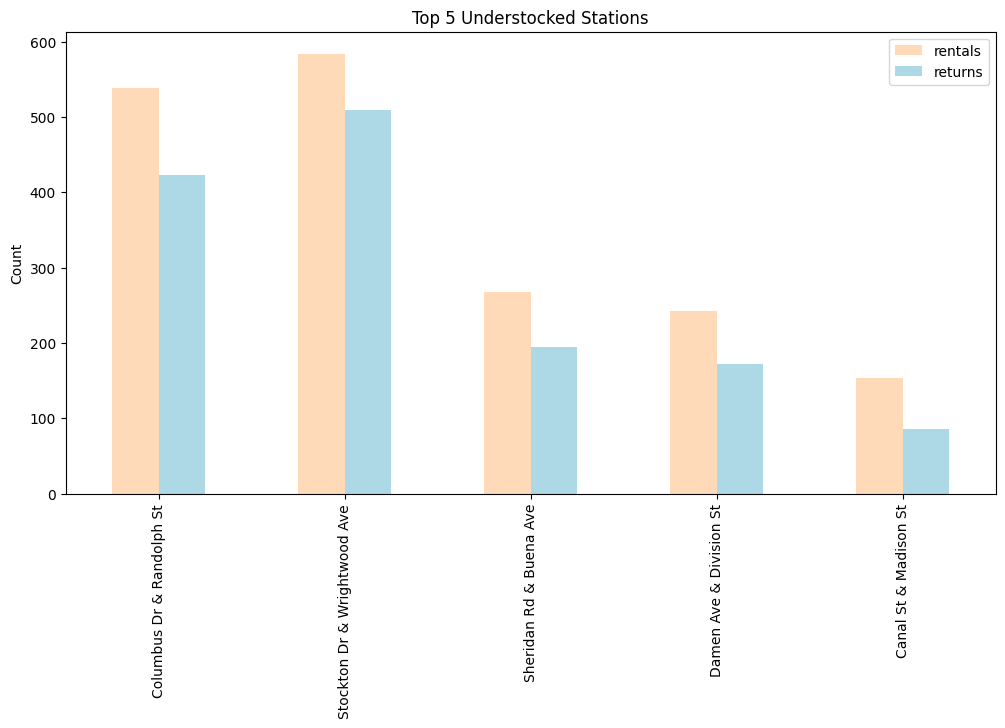

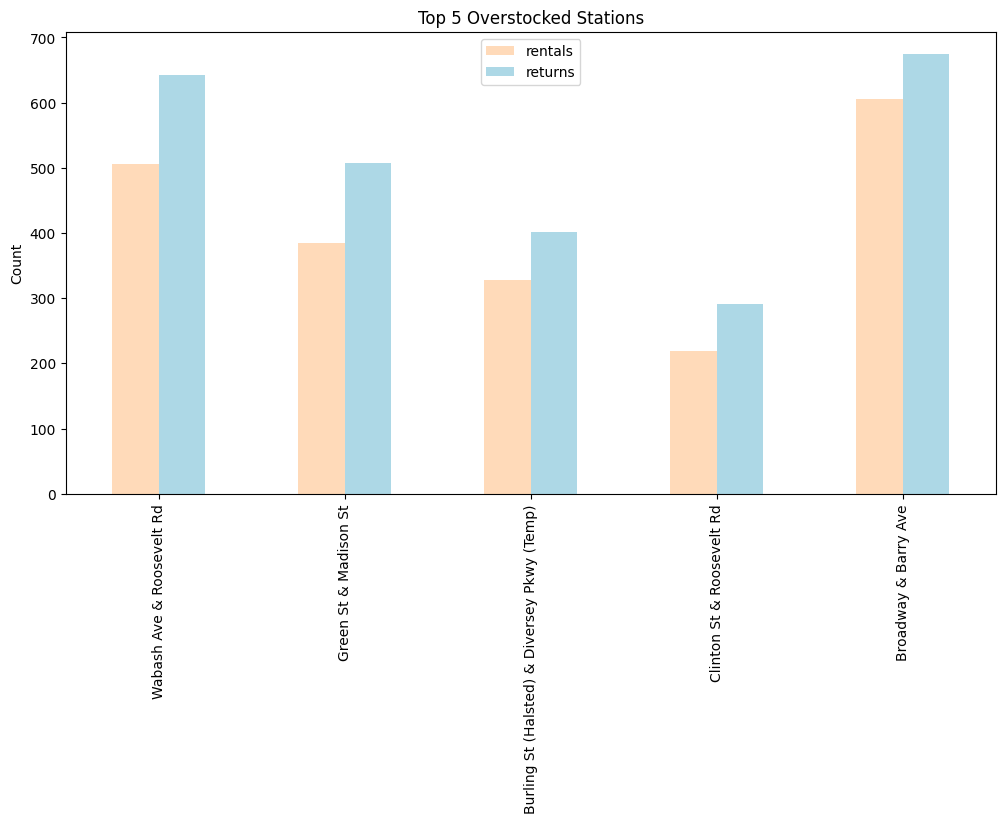

In [36]:
#Through supply-demand analysis, identify the most unbalanced stations in the bike-sharing system in terms of resource allocation, providing a basis for scheduling and resource optimization.
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('month_data.csv', parse_dates=['start_time', 'end_time'])

# Time-based features
data['hour_sin'] = np.sin(2 * np.pi * data['start_hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['start_hour'] / 24)
data['weekday_sin'] = np.sin(2 * np.pi * data['start_weekday'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['start_weekday'] / 7)

# Aggregate features
node_features = data.groupby('start_station_name').agg({
    'hour_sin': 'mean', 'hour_cos': 'mean',
    'weekday_sin': 'mean', 'weekday_cos': 'mean',
    'start_lat': 'mean', 'start_lng': 'mean'
}).reset_index()

# rentals and returns
rentals = data.groupby('start_station_name').size().rename('rentals')
returns = data.groupby('end_station_name').size().rename('returns')
node_features = pd.concat([node_features.set_index('start_station_name'), rentals, returns], axis=1).fillna(0)

# Normalize features (optional, can be skipped if not needed)
#scaler = MinMaxScaler()
#node_features[['rentals', 'returns']] = scaler.fit_transform(node_features[['rentals', 'returns']])

# Compute supply-demand difference
node_features['supply_demand_diff'] = node_features['returns'] - node_features['rentals']

# Add readable time features (reverse sin and cos to hour and weekday)
node_features['hour'] = np.arctan2(
    node_features['hour_sin'], node_features['hour_cos']
) * 24 / (2 * np.pi)
node_features['hour'] = node_features['hour'].apply(lambda x: x if x >= 0 else x + 24)  # Ensure hour is positive

node_features['weekday'] = np.arctan2(
    node_features['weekday_sin'], node_features['weekday_cos']
) * 7 / (2 * np.pi)
node_features['weekday'] = node_features['weekday'].apply(lambda x: int(x) if x >= 0 else int(x + 7))  # Convert to int

# Map weekday to readable names
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
node_features['weekday'] = node_features['weekday'].map(weekday_map)

# Find top 5 understocked stations (rentals > returns)
understocked_stations = node_features[node_features['supply_demand_diff'] < 0].nsmallest(5, 'supply_demand_diff')

# Find top 5 overstocked stations (returns > rentals)
overstocked_stations = node_features[node_features['supply_demand_diff'] > 0].nlargest(5, 'supply_demand_diff')


print("Top 5 Understocked Stations:")
print(understocked_stations[['rentals', 'returns', 'supply_demand_diff', 'weekday', 'hour']])

print("\nTop 5 Overstocked Stations:")
print(overstocked_stations[['rentals', 'returns', 'supply_demand_diff', 'weekday', 'hour']])

# visualization
understocked_stations[['rentals', 'returns']].plot(kind='bar', figsize=(12, 6), title='Top 5 Understocked Stations',color=['#FFDAB9', '#ADD8E6']  )
plt.ylabel('Count')
plt.show()
overstocked_stations[['rentals', 'returns']].plot(kind='bar', figsize=(12, 6), title='Top 5 Overstocked Stations',color=['#FFDAB9', '#ADD8E6']  )
plt.ylabel('Count')
plt.show()


Show these ten supply-demand imbalance stations on the map

In [37]:
import folium

m = folium.Map(location=[data['start_lat'].mean(), data['start_lng'].mean()], zoom_start=13)

# Understocked stations - Red
for _, row in understocked_stations.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=abs(row['supply_demand_diff']) / 10,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"{row.name}: {row['supply_demand_diff']}"
    ).add_to(m)

# Overstocked stations - Blue
for _, row in overstocked_stations.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=abs(row['supply_demand_diff']) / 10,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"{row.name}: {row['supply_demand_diff']}"
    ).add_to(m)

m.save('supply_demand_map.html')


Add borrowed/returned directed edges for each station

In [39]:
import folium
from folium.plugins import AntPath

# Load and preprocess data
data = pd.read_csv('1week_data.csv', parse_dates=['start_time', 'end_time'])

# Time-based features
data['hour_sin'] = np.sin(2 * np.pi * data['start_hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['start_hour'] / 24)
data['weekday_sin'] = np.sin(2 * np.pi * data['start_weekday'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['start_weekday'] / 7)

# Aggregate features
node_features = data.groupby('start_station_name').agg({
    'hour_sin': 'mean', 'hour_cos': 'mean',
    'weekday_sin': 'mean', 'weekday_cos': 'mean',
    'start_lat': 'mean', 'start_lng': 'mean'
}).reset_index()


m = folium.Map(location=[data['start_lat'].mean(), data['start_lng'].mean()], zoom_start=13)

# Understocked - Red
for _, row in understocked_stations.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=abs(row['supply_demand_diff']) / 10,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"{row.name}: {row['supply_demand_diff']}"
    ).add_to(m)

# Overstocked - Blue
for _, row in overstocked_stations.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=abs(row['supply_demand_diff']) / 10,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"{row.name}: {row['supply_demand_diff']}"
    ).add_to(m)

# Add a borrowing and returning route (using PolyLine)
for _, row in filtered_data.iterrows():
    if pd.notnull(row['start_lat']) and pd.notnull(row['end_lat']):
        folium.PolyLine(
            locations=[
                [row['start_lat'], row['start_lng']],
                [row['end_lat'], row['end_lng']]
            ],
            color='green',
            weight=2,
            dash_array='5,5',
            opacity=0.7,
            tooltip=f"{row['start_station_name']} → {row['end_station_name']}"
        ).add_to(m)

m.save('supply_demand_map_DirectedEdges.html')
